## original 16 stocks dataset

In [6]:
# for compatible with python 3
from __future__ import print_function
import os
# os.environ["KERAS_BACKEND"] = "theano"
import numpy as np
from utils.data import read_stock_history, index_to_date, date_to_index, normalize
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

In [8]:
# dataset for 16 stocks by splitting timestamp
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]

# 16 stocks are all involved. We choose first 3 years as training data
num_training_time = 1095
target_stocks = abbreviation
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))

for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

# and last 2 years as testing data.
testing_stocks = abbreviation
testing_history = np.empty(shape=(len(testing_stocks), history.shape[1] - num_training_time, 
                               history.shape[2]))
for i, stock in enumerate(testing_stocks):
    testing_history[i] = history[abbreviation.index(stock), num_training_time:, :]

In [9]:
nb_classes = len(target_stocks) + 1
print(target_history.shape)
print(testing_history.shape)

(16, 1095, 4)
(16, 730, 4)


In [10]:
# visualize 3 stock returns
if False:
    date_list = [index_to_date(i) for i in range(target_history.shape[1])]
    x = range(target_history.shape[1])
    for i in range(len(target_stocks)):
        plt.figure(i)
        plt.plot(x, target_history[i, :, 0])  # return, high, low, close = [0, 1, 2, 3]
        plt.xticks(x[::200], date_list[::200], rotation=30)
        plt.title(target_stocks[i])
        plt.show()

In [11]:
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

import numpy as np
import tflearn
import tensorflow as tf

from stock_trading import StockActor, StockCritic, obs_normalizer, get_model_path, get_result_path, \
                          test_model, get_variable_scope, test_model_multiple
    
from model.supervised.lstm import StockLSTM
from model.supervised.cnn import StockCNN

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [12]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

In [13]:
models = []
model_names = []
window_length_lst = [3, 7, 14, 21]
predictor_type_lst = ['cnn', 'lstm']
use_batch_norm = True

In [14]:
# instantiate environment, 16 stocks, with trading cost, window_length 3, start_date sample each time
for window_length in window_length_lst:
    for predictor_type in predictor_type_lst:
        name = 'DDPG_window_{}_predictor_{}'.format(window_length, predictor_type)
        model_names.append(name)
        tf.reset_default_graph()
        sess = tf.Session()
        tflearn.config.init_training_mode()
        action_dim = [nb_classes]
        state_dim = [nb_classes, window_length]
        variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
        with tf.variable_scope(variable_scope):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                               use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                                 predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(window_length, predictor_type, use_batch_norm)
            summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

            ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              config_file='config/stock.json', model_save_path=model_save_path,
                              summary_path=summary_path)
            ddpg_model.initialize(load_weights=True, verbose=False)
            models.append(ddpg_model)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_3/batch_norm/checkpoint.ckpt
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_3/batch_norm/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_7/batch_norm/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_7/batch_norm/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_14/batch_norm/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_1

In [15]:
# create another dataset
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target_2.h5')
history = history[:, :, :4]
nb_classes = len(history) + 1
print(history.shape)
testing_history = history
testing_stocks = abbreviation
target_history = history
target_stocks = abbreviation

(16, 1825, 4)


In [16]:
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv
env = MultiActionPortfolioEnv(target_history, target_stocks, model_names[:8], steps=1500, 
                              sample_start_date='2012-10-30')

Start date: 2012-10-30


<Figure size 720x432 with 0 Axes>

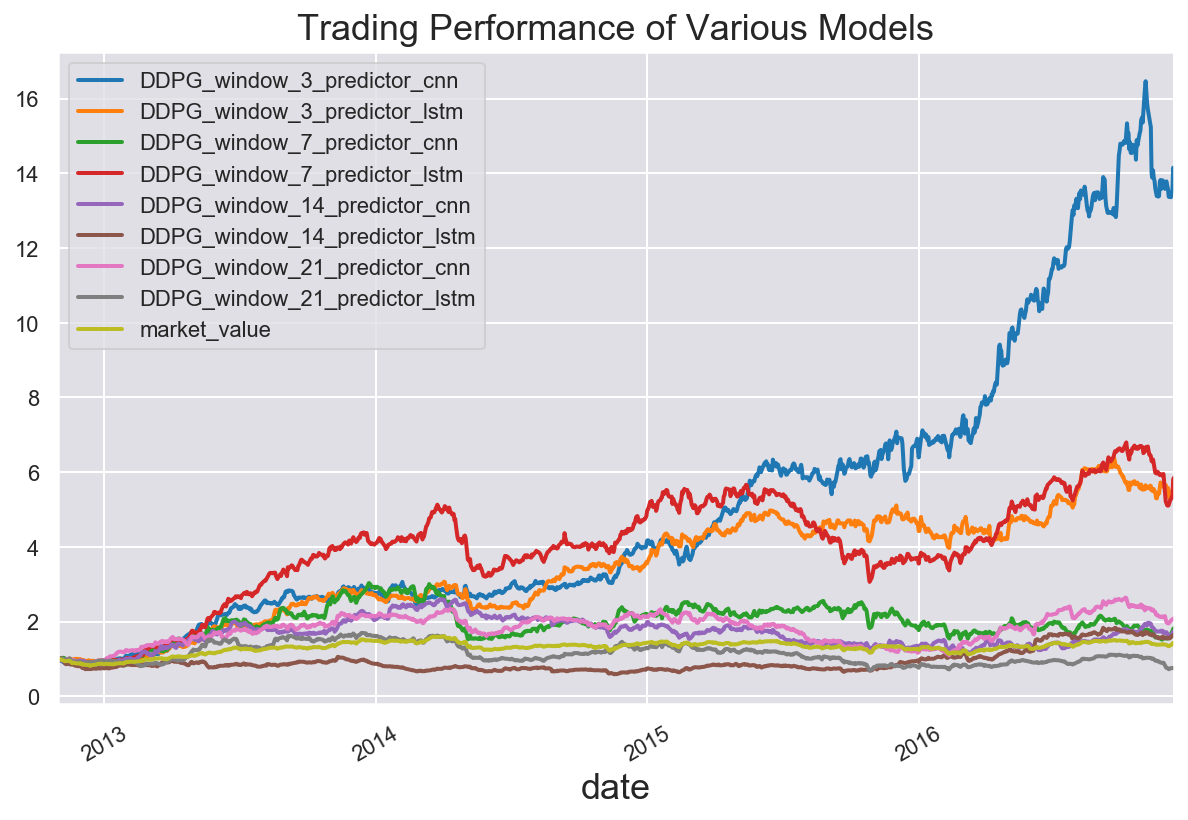

In [17]:
test_model_multiple(env, models[:8])

In [18]:
# evaluate the model with unseen data from same stock, fixed the starting date
env = MultiActionPortfolioEnv(testing_history, testing_stocks, model_names[:8], steps=650, start_idx=num_training_time, 
                   sample_start_date='2015-10-30')

Start date: 2012-10-30


<Figure size 720x432 with 0 Axes>

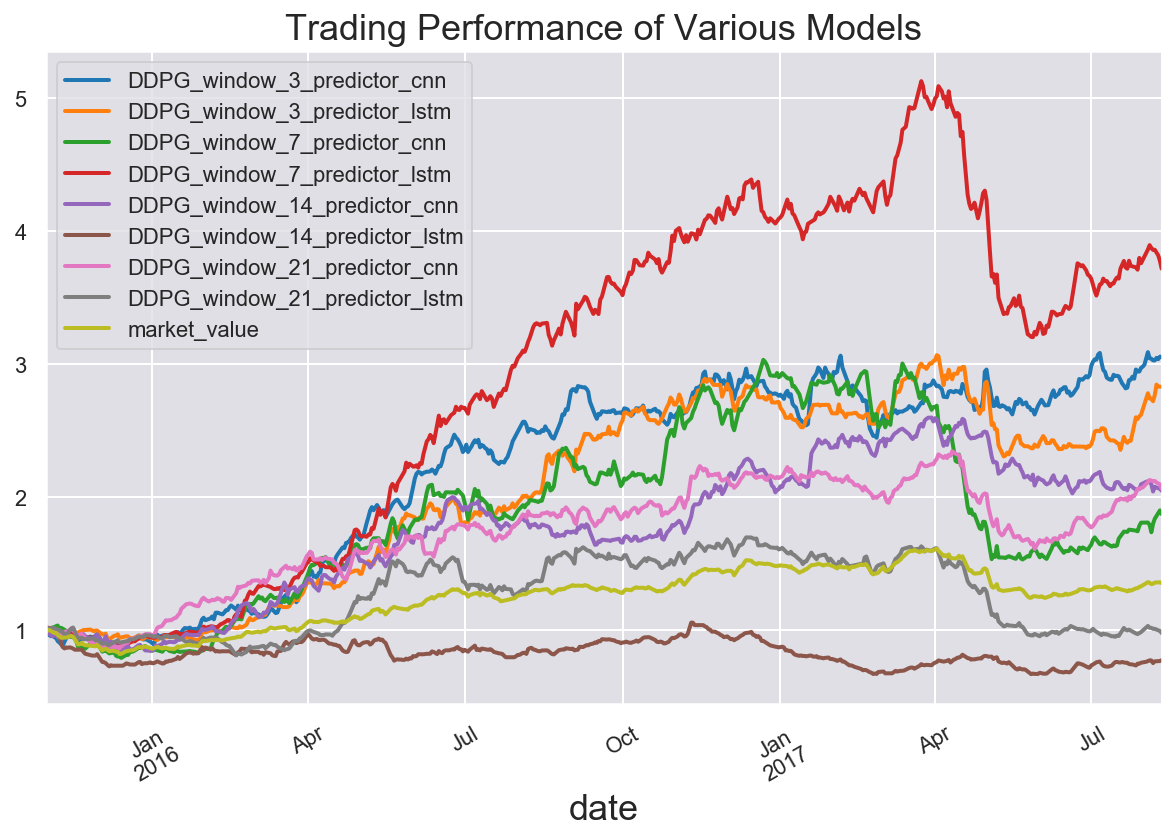

In [19]:
test_model_multiple(env, models[:8])

## 100 stocks dataset

In [28]:
import random
from utils.data import create_target_dataset

In [30]:
history, abbreviation = read_stock_history('utils/datasets/stocks_history_2.h5')

# create new dataset with 100 random stocks from entire dataset
random.seed(30)
new_list = random.sample(abbreviation,100)

create_target_dataset(new_list,filepath='utils/datasets/stocks_history_target3.h5')

In [31]:
# dataset for 100 stocks by splitting timestamp
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target3.h5')
history = history[:, :, :4]

# 100 stocks are all involved. We choose first 3 years as training data
num_training_time = 1095
target_stocks = abbreviation
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))

for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

# and last 2 years as testing data.
testing_stocks = abbreviation
testing_history = np.empty(shape=(len(testing_stocks), history.shape[1] - num_training_time, 
                               history.shape[2]))
for i, stock in enumerate(testing_stocks):
    testing_history[i] = history[abbreviation.index(stock), num_training_time:, :]

In [32]:
nb_classes = len(target_stocks) + 1
print(target_history.shape)
print(testing_history.shape)

(100, 1095, 4)
(100, 730, 4)


In [69]:
# create another dataset
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target3.h5')
history = history[:, :, :4]
nb_classes = len(history) + 1
print(history.shape)
testing_history = history
testing_stocks = abbreviation
target_history = history
target_stocks = abbreviation

(100, 1825, 4)


In [33]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

In [52]:
models = []
model_names = []
window_length_lst = [3, 7, 14, 21]
predictor_type_lst = ['cnn', 'lstm']
use_batch_norm = True

In [24]:
# instantiate environment, 100 stocks, with trading cost, window_length 3, start_date sample each time
# load weights = FALSE
for window_length in window_length_lst:
    for predictor_type in predictor_type_lst:
        name = 'DDPG_window_{}_predictor_{}'.format(window_length, predictor_type)
        model_names.append(name)
        tf.reset_default_graph()
        sess = tf.Session()
        tflearn.config.init_training_mode()
        action_dim = [nb_classes]
        state_dim = [nb_classes, window_length]
        variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
        with tf.variable_scope(variable_scope):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                               use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                                 predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(window_length, predictor_type, use_batch_norm)
            summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

            ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              config_file='config/stock.json', model_save_path=model_save_path,
                              summary_path=summary_path)
            ddpg_model.initialize(load_weights=False, verbose=True)
            models.append(ddpg_model)

Build model from scratch
Build model from scratch
Build model from scratch
Build model from scratch
Build model from scratch
Build model from scratch
Build model from scratch
Build model from scratch


In [25]:
env = MultiActionPortfolioEnv(target_history, target_stocks, model_names[:1], steps=1000, 
                              sample_start_date='2012-10-30')

Start date: 2012-10-30


In [27]:
target_stocks

[b'AAPL',
 b'ATVI',
 b'CMCSA',
 b'COST',
 b'CSX',
 b'DISH',
 b'EA',
 b'EBAY',
 b'FB',
 b'GOOGL',
 b'HAS',
 b'ILMN',
 b'INTC',
 b'MAR',
 b'REGN',
 b'SBUX']

<Figure size 720x432 with 0 Axes>

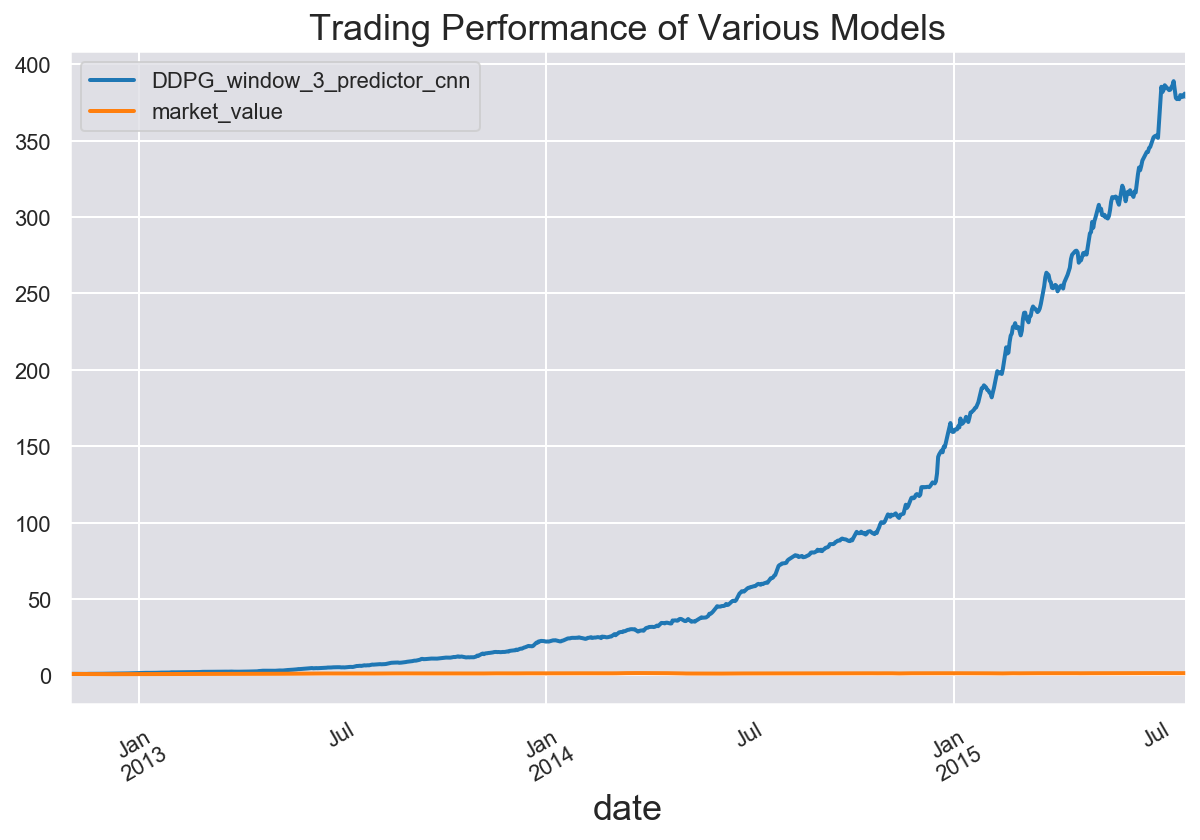

In [26]:
test_model_multiple(env, models[:1])

In [95]:
# evaluate the model with unseen data from same stock, fixed the starting date
env = MultiActionPortfolioEnv(testing_history, testing_stocks, model_names[:1], steps=650, start_idx=num_training_time, 
                   sample_start_date='2015-10-30')

Start date: 2012-10-30


<Figure size 720x432 with 0 Axes>

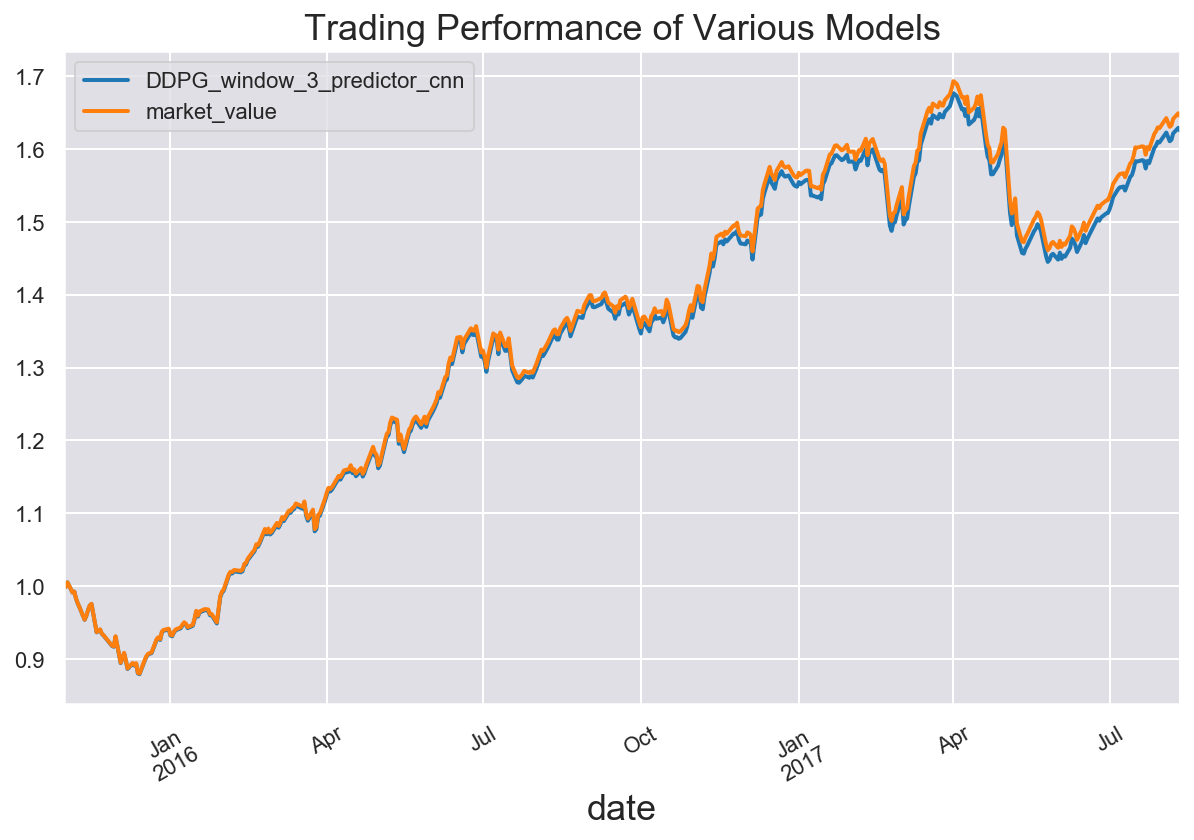

In [96]:
test_model_multiple(env, models[:1])

## new 16 stocks dataset

In [28]:
history, abbreviation = read_stock_history('utils/datasets/stocks_history_2.h5')

# create new dataset with new 16 random stocks from entire dataset
random.seed(2)
new_list = random.sample(abbreviation,16)

# rename each time or data will be overwritten
filepath = 'utils/datasets/stocks_history_target4.h5'

create_target_dataset(new_list,filepath=filepath)

NameError: name 'random' is not defined

In [144]:
# dataset for new 16 stocks by splitting timestamp
history, abbreviation = read_stock_history(filepath=filepath)
history = history[:, :, :4]

# new 16 stocks are all involved. We choose first 3 years as training data
num_training_time = 1095
target_stocks = abbreviation
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))

for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

# and last 2 years as testing data.
testing_stocks = abbreviation
testing_history = np.empty(shape=(len(testing_stocks), history.shape[1] - num_training_time, 
                               history.shape[2]))
for i, stock in enumerate(testing_stocks):
    testing_history[i] = history[abbreviation.index(stock), num_training_time:, :]

In [145]:
nb_classes = len(target_stocks) + 1
print(target_history.shape)
print(testing_history.shape)

(16, 1095, 4)
(16, 730, 4)


In [105]:
# instantiate environment, new 16 stocks, with trading cost, window_length 3, start_date sample each time
# load weights = TRUE
for window_length in window_length_lst:
    for predictor_type in predictor_type_lst:
        name = 'DDPG_window_{}_predictor_{}'.format(window_length, predictor_type)
        model_names.append(name)
        tf.reset_default_graph()
        sess = tf.Session()
        tflearn.config.init_training_mode()
        action_dim = [nb_classes]
        state_dim = [nb_classes, window_length]
        variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
        with tf.variable_scope(variable_scope):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                               use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                                 predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(window_length, predictor_type, use_batch_norm)
            summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

            ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              config_file='config/stock.json', model_save_path=model_save_path,
                              summary_path=summary_path)
            ddpg_model.initialize(load_weights=True, verbose=False)
            models.append(ddpg_model)

INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_3/batch_norm/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_3/batch_norm/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_7/batch_norm/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_7/batch_norm/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_14/batch_norm/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_14/batch_norm/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_21/batch_norm/checkpoint.ckpt
INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_21/batch_norm/checkpoint.ckpt


In [142]:
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv
env = MultiActionPortfolioEnv(target_history, target_stocks, model_names[:8], steps=1000, 
                              sample_start_date='2012-10-30')

Start date: 2012-10-30


<Figure size 720x432 with 0 Axes>

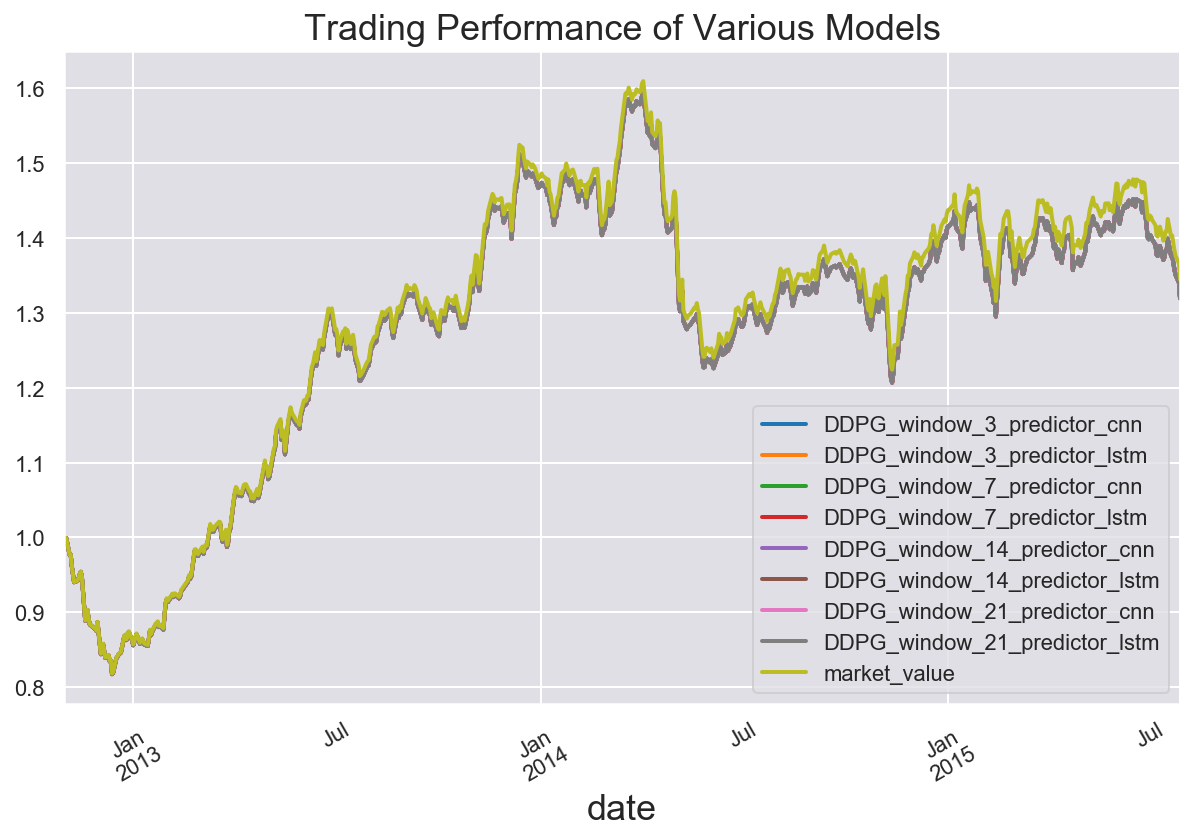

In [143]:
test_model_multiple(env, models[:8])

## Simulated MGARCH dataset